<a href="https://colab.research.google.com/github/ved-sharma/Digits_recognition_OpenCV_Python/blob/main/Digit_Recognizer_using_OpenCV_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook links to the GitHub repository at:

https://github.com/ved-sharma/Digits_recognition_OpenCV_Python

The code in this notebook was taken from the [excellent guide for recognizing digits](https://www.pyimagesearch.com/2017/02/13/recognizing-digits-with-opencv-and-python/) and adapted to recognize digits in the following image:

![](https://drive.google.com/uc?export=view&id=148BC6dW8PtiWEseaaNqiIHb_Blc09uDv)

In [225]:
#Install imutils, which has a series of convenience functions for basic image processing (https://github.com/jrosebr1/imutils)
!pip install imutils

In [226]:
# import the necessary packages
from imutils import contours
import imutils
import cv2
from google.colab.patches import cv2_imshow # OpenCV's cv2.imshow() does not work on Google Colab

# define the dictionary of digit segments so we can identify each digit
DIGITS_LOOKUP = {
	(1, 1, 1, 0, 1, 1, 1): 0,
	(0, 0, 1, 0, 0, 1, 0): 1,
	(1, 0, 1, 1, 1, 0, 1): 2,
	(1, 0, 1, 1, 0, 1, 1): 3,
	(0, 1, 1, 1, 0, 1, 0): 4,
	(1, 1, 0, 1, 0, 1, 1): 5,
	(1, 1, 0, 1, 1, 1, 1): 6,
	(1, 0, 1, 0, 0, 1, 0): 7,
	(1, 1, 1, 1, 1, 1, 1): 8,
	(1, 1, 1, 1, 0, 1, 1): 9
}

In [227]:
#@markdown #Play the cell to connect your Google Drive to Colab

#@markdown * Click on the URL. 
#@markdown * Sign in your Google Account. 
#@markdown * Copy the authorization code. 
#@markdown * Enter the authorization code. 
#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive". 
from google.colab import drive
drive.mount('/content/gdrive')

#@markdown If everything goes well, you would see a message: "Mounted at content/gdrive"   

#@markdown If you cannot see your files, reactivate your session by choosing "Connect to a hosted runtime" under the drop-down menu in top right beside the RAM/Disk progress bars.
# mount user's Google Drive to Google Colab.


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


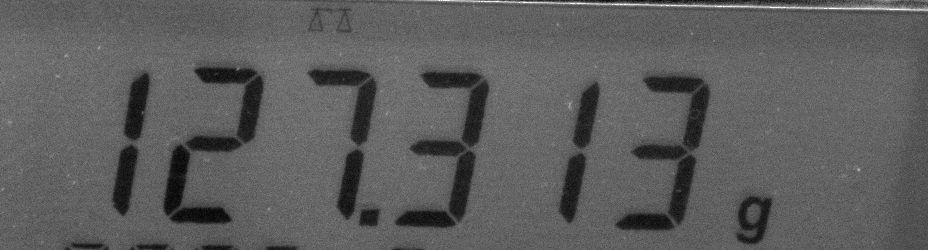

In [228]:
#@markdown #Load your image from Google Drive...
#@markdown Please enter fullpath to the image below:
image_path = "/content/gdrive/MyDrive/Scale Reading.PNG" #@param {type:"string"}
#@markdown **Tip:** The best way to do this it go to your Files on the left of this notebook, navigate through the folders to your image, copy the path by right-clicking on the image and selecting "Copy path" and pasting it into the box above. 

image = cv2.imread(image_path)
cv2_imshow(image)

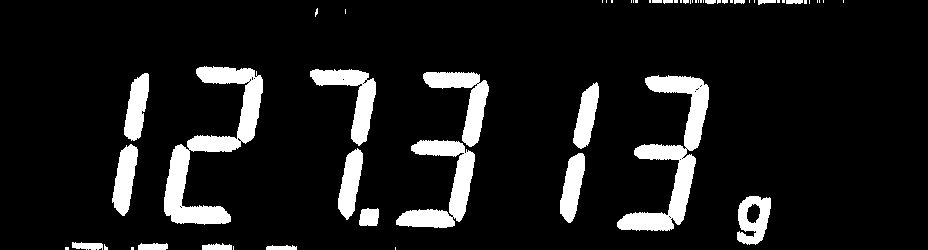

In [229]:
# convert image to grayscale, threshold and then apply a series of morphological
# operations to cleanup the thresholded image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 5))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
cv2_imshow(thresh)

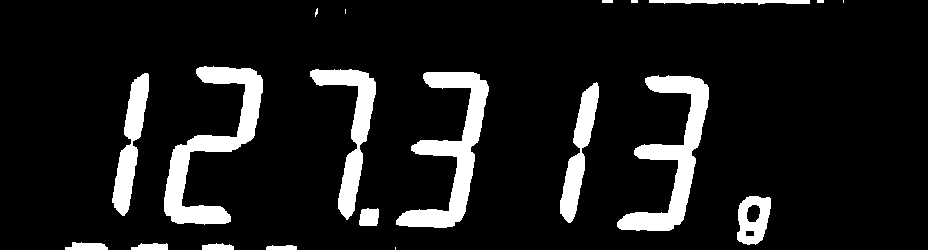

In [230]:
# Join the fragmented digit parts
import numpy as np
kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(thresh,kernel,iterations = 1)
erosion = cv2.erode(dilation,kernel,iterations = 1)
cv2_imshow(erosion)

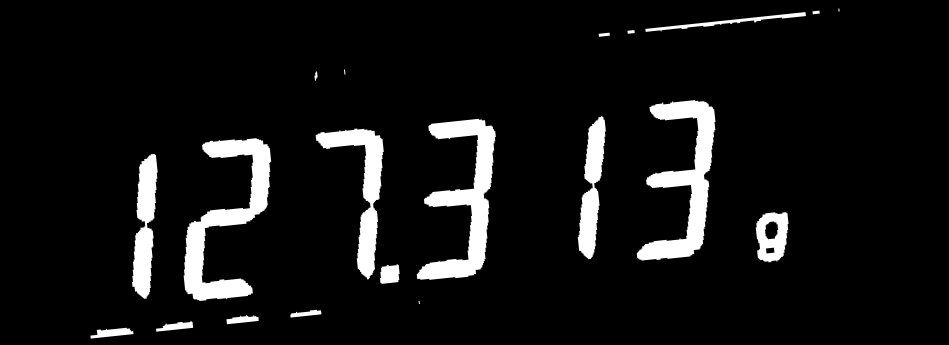

In [231]:
# Rotate the image, so the digits are straight
erosion = imutils.rotate_bound(erosion, -6)
cv2_imshow(erosion)

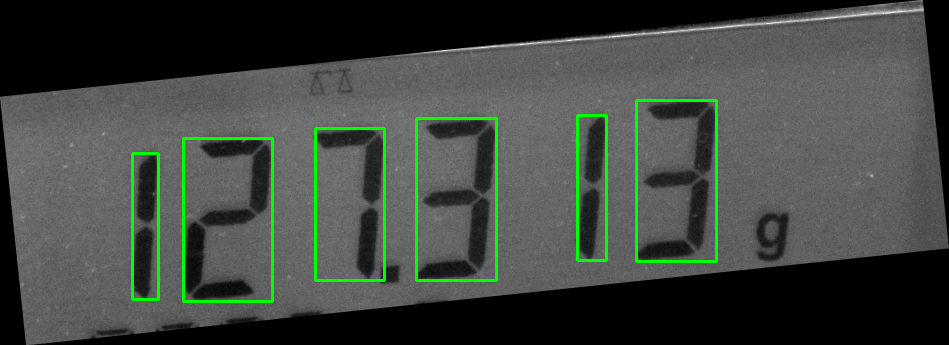

In [232]:
# find contours in the thresholded image, and put bounding box on the image
cnts = cv2.findContours(erosion.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
digitCnts = []
# loop over the digit area candidates
image_w_bbox = image.copy()
image_w_bbox = imutils.rotate_bound(image_w_bbox, -6)
#print("Printing (x, y, w, h) for each each bounding rectangle found in the image...")
for c in cnts:
  # compute the bounding box of the contour
  (x, y, w, h) = cv2.boundingRect(c)
#  print(x, y, w, h)
# if the contour is sufficiently large, it must be a digit
  if w >= 10 and (h >= 130 and h <= 170):
    digitCnts.append(c)
    image_w_bbox = cv2.rectangle(image_w_bbox,(x, y),(x+w, y+h),(0, 255, 0),2)
cv2_imshow(image_w_bbox)

In [233]:
# sort the contours from left-to-right
digitCnts = contours.sort_contours(digitCnts,	method="left-to-right")[0]
# len(digitCnts) # to check how many digits have been recognized

digits = []
# loop over each of the digits
for c in digitCnts:
	# extract the digit ROI
  (x, y, w, h) = cv2.boundingRect(c)
  if w<35: # it turns out we can recognize number 1 based on the ROI width
    digits.append(1)
  else: # for digits othan than the number 1
    roi = erosion[y:y + h, x:x + w]
    # compute the width and height of each of the 7 segments we are going to examine
    (roiH, roiW) = roi.shape
    (dW, dH) = (int(roiW * 0.25), int(roiH * 0.15))
    dHC = int(roiH * 0.05)
    # define the set of 7 segments
    segments = [
      ((0, 0), (w, dH)),	# top
      ((0, 0), (dW, h // 2)),	# top-left
      ((w - dW, 0), (w, h // 2)),	# top-right
      ((0, (h // 2) - dHC) , (w, (h // 2) + dHC)), # center
      ((0, h // 2), (dW, h)),	# bottom-left
      ((w - dW, h // 2), (w, h)),	# bottom-right
      ((0, h - dH), (w, h))	# bottom
    ]
    on = [0] * len(segments)
  # loop over the segments
    for (i, ((xA, yA), (xB, yB))) in enumerate(segments):
        # extract the segment ROI, count the total number of thresholded pixels
        # in the segment, and then compute the area of the segment
      segROI = roi[yA:yB, xA:xB]
      total = cv2.countNonZero(segROI)
      area = (xB - xA) * (yB - yA)
        # if the total number of non-zero pixels is greater than
        # 40% of the area, mark the segment as "on"
      if total / float(area) > 0.4:
        on[i]= 1
      # lookup the digit and draw it on the image
    digit = DIGITS_LOOKUP[tuple(on)]
    digits.append(digit)
print("Here are the digits from left to right...")
print(digits)

Here are the digits from left to right...
[1, 2, 7, 3, 1, 3]
